In [93]:
import tensorflow as tf
tf. config. list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [94]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [95]:
ds=tfds.load('fashion_mnist',split='train')

In [96]:
type(ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [97]:
ds.as_numpy_iterator().next()['label']

2

Visualize & Transform datasets

In [98]:
import numpy as np

In [99]:
#setup connection
dataiter = ds.as_numpy_iterator()

In [100]:
#getting data out of pipeline
dataiter.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

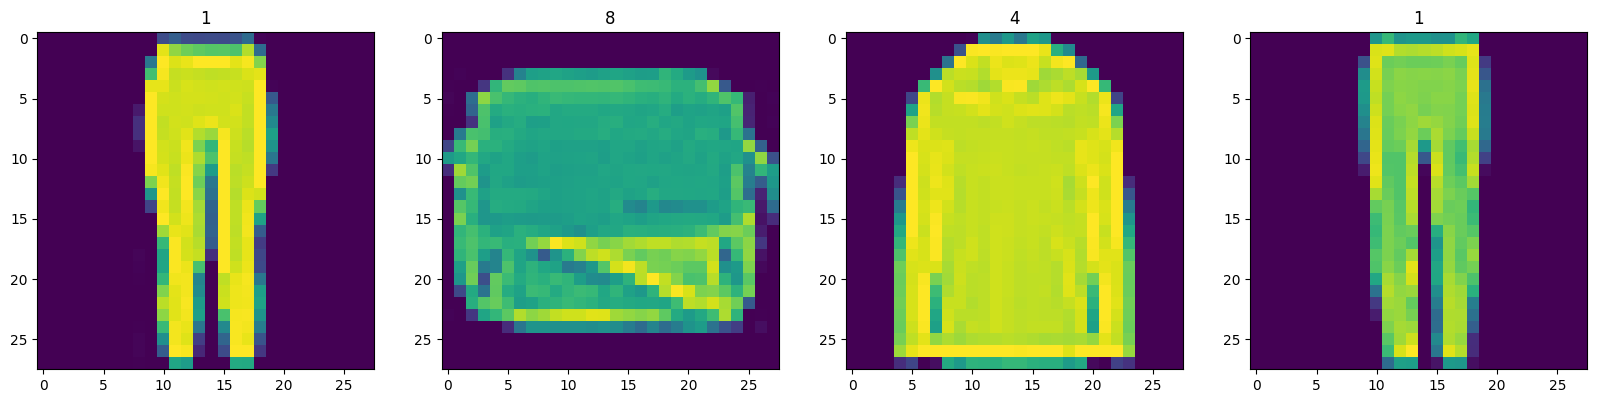

In [101]:
import numpy as np
fig,ax =plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  #grab image and label
    sample =dataiter.next()
    #plot image using specific subplot
    ax[idx].imshow(np.squeeze(sample['image']))
    #appending labes as plot title
    ax[idx].title.set_text(sample['label'])

In [102]:
def scale_images(data):
    image=data['image']
    return image/255

In [103]:
#dataset pipeline
ds=tfds.load('fashion_mnist',split='train')
#running the dataset through the scale_images preprocessing
ds = ds.map(scale_images)
#cache the dataset for that batch
ds =ds.cache()
#shuffle it up
ds = ds.shuffle(60000)
#batching into 128
ds= ds.batch(128)
#reduces the likelihood of bottlenecking
ds =ds.prefetch(64)

In [104]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

Build Neural Network

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout,UpSampling2D

In [106]:
#GENERATOR
def build_generator():
  model =Sequential()
  #takess random values and reshapes it to 7x7x128
  model.add(Dense(7*7*128,input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  #upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))


  #upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))


  #convulational block 1
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  #convulational block 2
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))


  #conv layer to one channel
  model.add(Conv2D(1,4,padding='same', activation='sigmoid'))

  return model


In [107]:
generator = build_generator()

In [108]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [109]:
img = generator.predict(np.random.randn(4,128,1)) #generate new fashion

1/1 [==============================] - 0s 97ms/step


In [110]:
img.shape

(4, 28, 28, 1)

In [111]:
'''img = generator.predict(np.random.randn(4,128,1)) #generate new fashion
#setting subplot formatting
fig,ax =plt.subplots(ncols=4, figsize=(20,20))
#loop four times and get images
for idx,img in enumerate(img):
    #plot image using specific subplot
    ax[idx].imshow(np.squeeze(img))
    #appending labes as plot title
    ax[idx].title.set_text(idx)'''

'img = generator.predict(np.random.randn(4,128,1)) #generate new fashion\n#setting subplot formatting\nfig,ax =plt.subplots(ncols=4, figsize=(20,20))\n#loop four times and get images\nfor idx,img in enumerate(img):\n    #plot image using specific subplot\n    ax[idx].imshow(np.squeeze(img))\n    #appending labes as plot title\n    ax[idx].title.set_text(idx)'

In [112]:
def build_discriminator():
  model = Sequential()

  #First Conv Block
  model.add(Conv2D(32,5,input_shape= (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Second Conv Block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Third Conv Block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Fourth Conv Block
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

  return model

In [113]:
discriminator = build_discriminator()

In [114]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)      

In [115]:
img.shape

(4, 28, 28, 1)

In [116]:
#img=img[0]
#img.shape

In [117]:
discriminator.predict(img)

1/1 [==============================] - 0s 78ms/step


array([[0.49821538],
       [0.49792817],
       [0.4978582 ],
       [0.49799427]], dtype=float32)

Constructing Training Loop

In [118]:
#setup Losses and Optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [119]:
g_opt =Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss =BinaryCrossentropy()
d_loss =BinaryCrossentropy()

In [120]:
#build ssubclass model
from tensorflow.keras.models import Model

In [121]:
tf.random.normal((6,128,1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 1.07687449e+00],
        [ 5.52347712e-02],
        [ 1.42414346e-01],
        [-8.20764899e-01],
        [-1.03509933e-01],
        [ 1.55344695e-01],
        [ 6.30971551e-01],
        [ 1.02733982e+00],
        [ 4.88691628e-02],
        [ 4.41691756e-01],
        [ 1.08630009e-01],
        [-1.13106191e+00],
        [-1.27946544e+00],
        [ 5.58507480e-02],
        [ 4.23528135e-01],
        [-6.15904272e-01],
        [ 4.10811067e-01],
        [-7.93633163e-02],
        [-1.99036360e-01],
        [-3.21509242e-02],
        [-1.29325283e+00],
        [-1.02878225e+00],
        [-2.53276706e-01],
        [ 9.04955447e-01],
        [-2.02999258e+00],
        [ 6.95842981e-01],
        [ 1.11517370e+00],
        [ 6.86953902e-01],
        [-1.30317962e+00],
        [ 1.05077136e+00],
        [ 1.30079126e+00],
        [-1.05338597e+00],
        [-8.56024325e-01],
        [-3.94863114e-02],
        [ 1.17380701e-01],
  

In [122]:
from tensorflow.keras.models import Model

In [123]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [124]:
#create instanceof subclass model
fashgan = FashionGAN(generator,discriminator)

In [125]:
#compile the model
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

Build Callback

In [126]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [127]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

Train

In [128]:
#recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 86s 159ms/step - d_loss: 0.4864 - g_loss: 1.1819
Epoch 2/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.3092 - g_loss: 3.7718
Epoch 3/20
469/469 [==============================] - 77s 165ms/step - d_loss: 0.2751 - g_loss: 2.6369
Epoch 4/20
469/469 [==============================] - 78s 166ms/step - d_loss: 0.2737 - g_loss: 2.6897
Epoch 5/20
469/469 [==============================] - 78s 166ms/step - d_loss: 0.2731 - g_loss: 2.7369
Epoch 6/20
469/469 [==============================] - 78s 166ms/step - d_loss: 0.2719 - g_loss: 2.7621
Epoch 7/20
469/469 [==============================] - 78s 165ms/step - d_loss: 0.2711 - g_loss: 2.7813
Epoch 8/20
469/469 [==============================] - 78s 166ms/step - d_loss: 0.5926 - g_loss: 1.0353
Epoch 9/20
469/469 [==============================] - 78s 167ms/step - d_loss: 0.4660 - g_loss: 0.3409
Epoch 10/20
469/469 [==============================] - 78s 166ms/step - d

Review Performances

In [129]:
hist.history

{'d_loss': [0.4528748691082001,
  0.277391254901886,
  0.26880019903182983,
  0.26892802119255066,
  0.27623289823532104,
  0.26163896918296814,
  0.271558940410614,
  0.6924184560775757,
  0.35195493698120117,
  0.31223195791244507,
  0.7099090218544006,
  0.7139647603034973,
  0.7155265808105469,
  0.6922693252563477,
  0.7138104438781738,
  0.6492168307304382,
  0.7119792103767395,
  0.7001826167106628,
  0.6874402165412903,
  0.7000744938850403],
 'g_loss': [2.252979040145874,
  2.6082091331481934,
  2.673661708831787,
  2.722169876098633,
  2.7323851585388184,
  2.791154623031616,
  2.8064932823181152,
  0.31819823384284973,
  0.08491579443216324,
  0.09116418659687042,
  0.6137092113494873,
  0.6170967221260071,
  0.5815997123718262,
  0.6385353803634644,
  0.5941183567047119,
  0.6491738557815552,
  0.6216840744018555,
  0.6333971619606018,
  0.7164229154586792,
  0.665489673614502]}

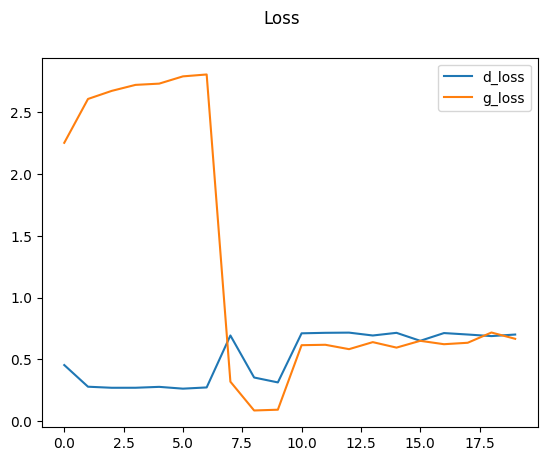

In [130]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

Test Out the Generator

In [139]:
generator.load_weights( 'generator.h5')

In [140]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 19ms/step


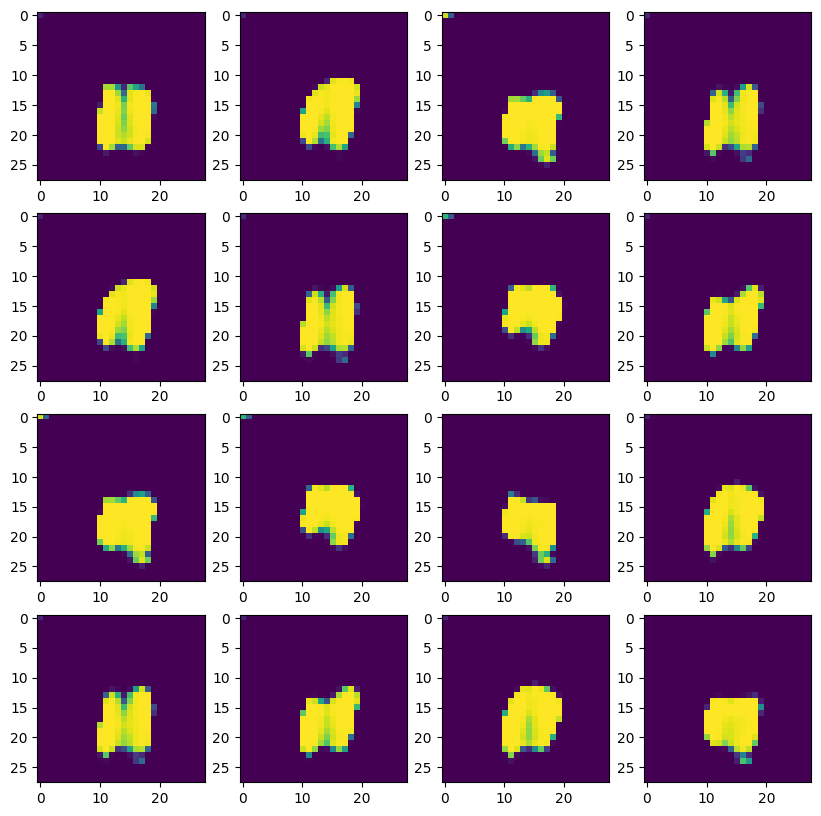

In [141]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

Save Trained Model

In [136]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
